In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F


from glob import glob
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

!mkdir output
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pio.renderers.default = 'iframe'

�T�u�f�B���N�g���܂��̓t�@�C�� output �͊��ɑ��݂��܂��B


In [53]:
class config:
    AMP = False
    BATCH_SIZE_TRAIN = 3 #32
    BATCH_SIZE_VALID = 3 #32
    DEBUG = False
    EPOCHS = 3  #30
    FOLDS = 5
    GRADIENT_ACCUMULATION_STEPS = 1
    LEARNING_RATE = 1e-3
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    WEIGHT_DECAY = 0.01


class paths:
    OUTPUT_DIR = "C:\\Users\\konno\\SynologyDrive\\datasciense\\projects_foler\\1_kaggle\\CMI\\cmi-detect-behavior-with-sensor-data\\output"
    TEST_CSV = "C:\\Users\\konno\\SynologyDrive\\datasciense\\projects_foler\\1_kaggle\\CMI\\cmi-detect-behavior-with-sensor-data\\test.csv"
    TEST_DEMOGRAPHICS = "C:\\Users\\konno\\SynologyDrive\\datasciense\\projects_foler\\1_kaggle\\CMI\\cmi-detect-behavior-with-sensor-data\\test_demographics.csv"
    TRAIN_CSV = "C:\\Users\\konno\\SynologyDrive\\datasciense\\projects_foler\\1_kaggle\\CMI\\cmi-detect-behavior-with-sensor-data\\train.csv"
    TRAIN_DEMOGRAPHICS = "C:\\Users\\konno\\SynologyDrive\\datasciense\\projects_foler\\1_kaggle\\CMI\\cmi-detect-behavior-with-sensor-data\\train_demographics.csv"

In [54]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def format_for_scoring(df_preds: pd.DataFrame) ->tuple[pd.DataFrame, pd.DataFrame]: 
    solution = df_preds[["sequence_id", "y_true"]].copy()
    solution.columns = ["id", "gesture"]
    solution["gesture"] = solution["gesture"].map(num_to_label)

    submission = df_preds[["sequence_id", "y_pred"]].copy()
    submission.columns = ["id", "gesture"]
    submission["gesture"] = submission["gesture"].map(num_to_label)
    
    return solution, submission
    

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    

def sep():
    print("—"*100)


label_to_num = {
    'Above ear - pull hair': 0,  # < ------- TARGETS START
    'Cheek - pinch skin': 1,
    'Eyebrow - pull hair': 2,
    'Eyelash - pull hair': 3,
    'Forehead - pull hairline': 4,
    'Forehead - scratch': 5,
    'Neck - pinch skin': 6,
    'Neck - scratch': 7,  # < ------- TARGETS END
    'Drink from bottle/cup': 8,  # < ------- NON-TARGETS START
    'Feel around in tray and pull out an object': 8,
    'Glasses on/off': 8,
    'Pinch knee/leg skin': 8,
    'Pull air toward your face': 8,
    'Scratch knee/leg skin': 8,
    'Text on phone': 8,
    'Wave hello': 8,
    'Write name in air': 8,
    'Write name on leg': 8  # < ------- NON-TARGETS END
}
type_to_num = {"Target": 1, "Non-Target":0}
num_to_label = {v: k for k, v in label_to_num.items()}
num_to_type = {v: k for k, v in type_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

In [56]:
df_train = pd.read_csv(paths.TRAIN_CSV)[:500]
df_test = pd.read_csv(paths.TEST_CSV)
df_train_demographics = pd.read_csv(paths.TRAIN_DEMOGRAPHICS)[:500]
df_test_demographics = pd.read_csv(paths.TEST_DEMOGRAPHICS)

print(f"Train dataframe shape: {df_train.shape}"), sep()
print(f"Tesat dataframe shape: {df_test.shape}"), sep()
print(f"Train demographics dataframe shape: {df_train_demographics.shape}"), sep()
print(f"Test demographics dataframe shape: {df_test_demographics.shape}")

display(df_train.head())
display(df_train_demographics.head())

Train dataframe shape: (500, 341)
————————————————————————————————————————————————————————————————————————————————————————————————————
Tesat dataframe shape: (107, 336)
————————————————————————————————————————————————————————————————————————————————————————————————————
Train demographics dataframe shape: (81, 8)
————————————————————————————————————————————————————————————————————————————————————————————————————
Test demographics dataframe shape: (2, 8)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,...,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,-1.0,-1.0,-1.0,-1.0,169.0,118.0,86.0,73.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,140.0,119.0,135.0,156.0,166.0,-1.0,-1.0,155.0,137.0,112.0,148.0,163.0,164.0,153.0,133.0,131.0,121.0,118.0,134.0,134.0,128.0,121.0,119.0,121.0,129.0,-1.0,113.0,124.0,122.0,131.0,-1.0,-1.0,-1.0,-1.0,120.0,127.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,6.214844,3.125000,0.143494,-0.340271,-0.428650,-0.824524,29.340816,31.874645,29.791740,28.663383,28.406172,130.0,138.0,131.0,135.0,101.0,76.0,66.0,61.0,-1.0,-1.0,156.0,155.0,141.0,93.0,74.0,64.0,-1.0,-1.0,-1.0,-1.0,165.0,116.0,86.0,75.0,130.0,-1.0,-1.0,-1.0,-1.0,...,142.0,122.0,138.0,157.0,-1.0,-1.0,-1.0,155.0,133.0,117.0,145.0,170.0,163.0,157.0,139.0,127.0,126.0,121.0,136.0,142.0,133.0,127.0,123.0,127.0,134.0,-1.0,116.0,122.0,123.0,126.0,-1.0,-1.0,-1.0,-1.0,122.0,129.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,5.410156,5.421875,0.219055,-0.274231,-0.356934,-0.865662,30.339359,30.935045,30.090014,28.796087,28.529778,137.0,136.0,147.0,109.0,90.0,81.0,74.0,74.0,-1.0,164.0,165.0,146.0,106.0,94.0,77.0,77.0,-1.0,-1.0,-1.0,180.0,140.0,118.0,103.0,92.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,145.0,139.0,138.0,164.0,-1.0,-1.0,-1.0,-1.0,145.0,120.0,151.0,165.0,-1.0,-1.0,-1.0,151.0,138.0,127.0,151.0,187.0,-1.0,156.0,136.0,135.0,134.0,-1.0,133.0,142.0,131.0,130.0,132.0,136.0,-1.0,-1.0,112.0,121.0,123.0,125.0,-1.0,-1.0,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,3.531250,6.457031,0.297546,-0.264160,-0.238159,-0.885986,30.543730,27.044001,29.310717,29.018711,27.402010,143.0,147.0,170.0,127.0,109.0,98.0,95.0,95.0,-1.0,177.0,189.0,177.0,136.0,121.0,107.0,104.0,-1.0,-1.0,-1.0,202.0,171.0,160.0,141.0,135.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,133.0,-1.0,162.0,181.0,-1.0,-1.0,-1.0,152.0,134.0,-1.0,148.0,187.0,-1.0,-1.0,149.0,142.0,135.0,-1.0,159.0,181.0,150.0,135.0,129.0,139.0,-1.0,-1.0,141.0,136.0,120.0,122.0,132.0,-1.0,-1.0,-1.0,107.0,112.0,115.0,140.0,-1.0,-1.0,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,0.277344,9.632812,0.333557,-0.218628,-0

,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0
3,SUBJ_003328,1,33,1,1,171.0,52,25.0
4,SUBJ_004117,0,15,0,1,184.0,54,28.0


### Data Pre-Processing

In [57]:
df_train["target"] = df_train["gesture"].map(label_to_num)
df_train.drop(columns=["behavior", "orientation"], inplace=True)  # TODO: use LabelEncoder
df_train["sequence_type"] = df_train["sequence_type"].map(type_to_num)
df_train.reset_index(inplace=True)

In [58]:
df_train.head(2)

,index,row_id,sequence_type,sequence_id,sequence_counter,subject,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,...,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,target
0,0,SEQ_000007_000000,1,SEQ_000007,0,SUBJ_059520,Transition,Cheek - pinch skin,6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,-1.0,-1.0,-1.0,-1.0,169.0,118.0,86.0,73.0,-1.0,-1.0,-1.0,-1.0,-1.0,147.0,...,119.0,135.0,156.0,166.0,-1.0,-1.0,155.0,137.0,112.0,148.0,163.0,164.0,153.0,133.0,131.0,121.0,118.0,134.0,134.0,128.0,121.0,119.0,121.0,129.0,-1.0,113.0,124.0,122.0,131.0,-1.0,-1.0,-1.0,-1.0,120.0,127.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,1,SEQ_000007_000001,1,SEQ_000007,1,SUBJ_059520,Transition,Cheek - pinch skin,6.949219,6.214844,3.125000,0.143494,-0.340271,-0.428650,-0.824524,29.340816,31.874645,29.791740,28.663383,28.406172,130.0,138.0,131.0,135.0,101.0,76.0,66.0,61.0,-1.0,-1.0,156.0,155.0,141.0,93.0,74.0,64.0,-1.0,-1.0,-1.0,-1.0,165.0,116.0,86.0,75.0,130.0,-1.0,-1.0,-1.0,-1.0,142.0,...,122.0,138.0,157.0,-1.0,-1.0,-1.0,155.0,133.0,117.0,145.0,170.0,163.0,157.0,139.0,127.0,126.0,121.0,136.0,142.0,133.0,127.0,123.0,127.0,134.0,-1.0,116.0,122.0,123.0,126.0,-1.0,-1.0,-1.0,-1.0,122.0,129.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1


### Validation

In [19]:
# !pip install scikit-learn

In [70]:
from sklearn.model_selection import KFold, StratifiedGroupKFold
# 正解ラベルの割合が同じになるようにデータを分割するのがStratified K-Fold

sgkf = StratifiedGroupKFold(n_splits=config.FOLDS)
for fold, (train_index, valid_index) in enumerate(sgkf.split(df_train, df_train.target, df_train.subject)):
    df_train.loc[valid_index, "fold"] = int(fold)
    
display(df_train.groupby('fold').size()), sep()
display(df_train.head())

fold
0.0    159
1.0     61
2.0    105
3.0     68
4.0    107
dtype: int64

————————————————————————————————————————————————————————————————————————————————————————————————————


,index,row_id,sequence_type,sequence_id,sequence_counter,subject,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,...,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63,target,fold
0,0,SEQ_000007_000000,1,SEQ_000007,0,SUBJ_059520,Transition,Cheek - pinch skin,6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,-1.0,-1.0,-1.0,-1.0,169.0,118.0,86.0,73.0,-1.0,-1.0,-1.0,-1.0,-1.0,147.0,...,135.0,156.0,166.0,-1.0,-1.0,155.0,137.0,112.0,148.0,163.0,164.0,153.0,133.0,131.0,121.0,118.0,134.0,134.0,128.0,121.0,119.0,121.0,129.0,-1.0,113.0,124.0,122.0,131.0,-1.0,-1.0,-1.0,-1.0,120.0,127.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,2.0
1,1,SEQ_000007_000001,1,SEQ_000007,1,SUBJ_059520,Transition,Cheek - pinch skin,6.949219,6.214844,3.125000,0.143494,-0.340271,-0.428650,-0.824524,29.340816,31.874645,29.791740,28.663383,28.406172,130.0,138.0,131.0,135.0,101.0,76.0,66.0,61.0,-1.0,-1.0,156.0,155.0,141.0,93.0,74.0,64.0,-1.0,-1.0,-1.0,-1.0,165.0,116.0,86.0,75.0,130.0,-1.0,-1.0,-1.0,-1.0,142.0,...,138.0,157.0,-1.0,-1.0,-1.0,155.0,133.0,117.0,145.0,170.0,163.0,157.0,139.0,127.0,126.0,121.0,136.0,142.0,133.0,127.0,123.0,127.0,134.0,-1.0,116.0,122.0,123.0,126.0,-1.0,-1.0,-1.0,-1.0,122.0,129.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,2.0
2,2,SEQ_000007_000002,1,SEQ_000007,2,SUBJ_059520,Transition,Cheek - pinch skin,5.722656,5.410156,5.421875,0.219055,-0.274231,-0.356934,-0.865662,30.339359,30.935045,30.090014,28.796087,28.529778,137.0,136.0,147.0,109.0,90.0,81.0,74.0,74.0,-1.0,164.0,165.0,146.0,106.0,94.0,77.0,77.0,-1.0,-1.0,-1.0,180.0,140.0,118.0,103.0,92.0,-1.0,-1.0,-1.0,-1.0,-1.0,155.0,...,138.0,164.0,-1.0,-1.0,-1.0,-1.0,145.0,120.0,151.0,165.0,-1.0,-1.0,-1.0,151.0,138.0,127.0,151.0,187.0,-1.0,156.0,136.0,135.0,134.0,-1.0,133.0,142.0,131.0,130.0,132.0,136.0,-1.0,-1.0,112.0,121.0,123.0,125.0,-1.0,-1.0,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,2.0
3,3,SEQ_000007_000003,1,SEQ_000007,3,SUBJ_059520,Transition,Cheek - pinch skin,6.601562,3.531250,6.457031,0.297546,-0.264160,-0.238159,-0.885986,30.543730,27.044001,29.310717,29.018711,27.402010,143.0,147.0,170.0,127.0,109.0,98.0,95.0,95.0,-1.0,177.0,189.0,177.0,136.0,121.0,107.0,104.0,-1.0,-1.0,-1.0,202.0,171.0,160.0,141.0,135.0,-1.0,-1.0,-1.0,-1.0,-1.0,197.0,...,162.0,181.0,-1.0,-1.0,-1.0,152.0,134.0,-1.0,148.0,187.0,-1.0,-1.0,149.0,142.0,135.0,-1.0,159.0,181.0,150.0,135.0,129.0,139.0,-1.0,-1.0,141.0,136.0,120.0,122.0,132.0,-1.0,-1.0,-1.0,107.0,112.0,115.0,140.0,-1.0,-1.0,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,2.0
4,4,SEQ_000007_000004,1,SEQ_000007,4,SUBJ_059520,Transition,Cheek - pinch skin,5.566406,0.277344,9.632812,0.333557,-0.218628,-0.063538,-0.914856,29.317265,25.270855,26.808746,29.408604,27.357603,178.0,191.0,183.0,157.0,146.0,139.0,143.0,148.0,-1.0,-1.0,236.0,238.0,208.0,200.0,185.0,190.0,-1.0,-1.0,-1.0,210.0,246.0,225.0,228.0,202.0,149.0,206.0,219.0,219.0,225.0,218.0,...,197.0,-1.0,-1.0,219.0,192.0,-1.0,-1.0,-1.0,204.0,-1.0,-1.0,212.0,181.0,-1.0,-1.0,-1.0,184.0,-1.0,179.0,162.0,-1.0,-1.0,-1.0,-1.0,169.0,171.0,145.0,140

In [71]:
def min_max_scale(arr: np.ndarray) -> np.ndarray:
    min_vals = np.nanmin(arr, axis=0)
    max_vals = np.nanmax(arr, axis=0)
    ranges = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
    scaled = (arr - min_vals) / ranges
    return scaled


def standard_scale(arr: np.ndarray) -> np.ndarray:
    means = np.nanmean(arr, axis=0)
    stds = np.nanstd(arr, axis=0)
    stds = np.where(stds == 0, 1, stds)  # Prevent division by zero for constant columns
    scaled = (arr - means) / stds
    return scaled


def pad_or_truncate(
    arr: np.ndarray,
    max_length: int = 200,
    pad_value: int = 0,
    mode: str = "random"  # "regular" or "random"
) -> np.ndarray:
    L, D = arr.shape

    if L > max_length:
        return arr[:max_length, :]

    elif L < max_length:
        if mode == "regular":
            padding = np.full((max_length - L, D), pad_value)
            return np.vstack((arr, padding))
        
        elif mode == "random":
            total_padding = max_length - L
            pad_start = np.random.randint(0, total_padding + 1)
            pad_end = total_padding - pad_start

            start_padding = np.full((pad_start, D), pad_value)
            end_padding = np.full((pad_end, D), pad_value)

            return np.vstack((start_padding, arr, end_padding))
        
        else:
            raise ValueError(f"Unknown mode: {mode}. Use 'regular' or 'random'.")

    else:
        return arr

imu_cols = ["acc_x", "acc_y", "acc_z", "rot_w", "rot_x", "rot_y", "rot_z"]
all_X, all_y, all_y_hard = [], [], []

for sequence_id in tqdm(df_train.sequence_id.unique()):
    # Iterate by sequence id: the batch of sensor data
    ds = df_train[df_train["sequence_id"] == sequence_id]
    X = ds[imu_cols].values
    X = pad_or_truncate(X)
    y = ds.target.values[0]
    y_hard = ds.sequence_type.values[0]
    X = np.concatenate((standard_scale(X[:, 0:3]), X[:, 3:]), axis=1)
    X = np.where(np.isnan(X), 0.0, X)  # fill NaNs
    all_X.append(X)
    all_y.append(y)
    all_y_hard.append(y_hard)

all_X = np.array(all_X)
all_y = np.array(all_y)
all_y_hard = np.array(all_y_hard)

100%|██████████| 7/7 [00:00<00:00, 371.21it/s]


In [72]:
class CustomDataset(Dataset):
    def __init__(
        self, config, df: pd.DataFrame, X: np.ndarray, y: np.ndarray, y_hard: np.ndarray
    ): 
        
        self.config = config
        self.df = df
        self.X = X
        self.y = y
        self.y_hard = y_hard
        self.indexes = self.df.sequence_id.unique()
        
    def __len__(self):
        """
        Length of dataset.
        """
        return len(self.indexes)
        
    def __getitem__(self, index):
        """
        Get one item.
        """
        sequence_id = self.indexes[index]
        X = self.X[index]
        y = self.y[index]
        y_hard = self.y_hard[index]
        output = {
            "X": torch.tensor(X, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.long),
            "y_hard": torch.tensor(y_hard, dtype=torch.float32),
            "sequence_id": sequence_id
        }
        return output     

In [73]:
train_dataset = CustomDataset(config, df_train, all_X, all_y, all_y_hard)

#### Print out
sample = train_dataset[0]

sample_X = sample["X"]
sample_y = sample["y"]
sample_y_hard = sample["y_hard"]
sequence_id = sample["sequence_id"]

print("Sample X shape:", sample_X.shape)
print("Sample y:", sample_y)
print("Sample y_hard:", sample_y_hard)
print("Sequence ID:", sequence_id)
print("Length of train_dataset:", len(train_dataset))
#### END


train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)
idx = np.random.choice(range(0, len(train_dataset)))
cols = imu_cols
X = train_dataset[idx]["X"]
y = train_dataset[idx]["y"].item()
y_hard = train_dataset[idx]["y_hard"].item()
target = num_to_label[y]
sequence_id = train_dataset[idx]["sequence_id"]
N = X.shape[0]
df = pd.DataFrame(X, columns=cols)
df['step'] = range(N)
df_melted = df.melt(id_vars='step', var_name='sequence', value_name='value')

fig = px.line(
    df_melted,
    x='step',
    y='value',
    color='sequence',
    title=f"Sequences for {sequence_id} | Target: {target}",
    template='plotly_dark',
    width=800,
    height=600
)
print(len(train_loader))
fig.show(renderer='browser')

Sample X shape: torch.Size([200, 7])
Sample y: tensor(1)
Sample y_hard: tensor(1.)
Sequence ID: SEQ_000007
Length of train_dataset: 7
2


In [63]:
class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        # First conv: (B, in_channels, L) -> (B, out_channels, L)
        self.convs.append(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True)
        )
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            # Filter conv: (B, out_channels, L) -> (B, out_channels, L)
            self.filter_convs.append(
                nn.Conv1d(
                    out_channels, out_channels, kernel_size=kernel_size,
                    padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate)
            )
            # Gate conv: (B, out_channels, L) -> (B, out_channels, L)
            self.gate_convs.append(
                nn.Conv1d(
                    out_channels, out_channels, kernel_size=kernel_size,
                    padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate)
            )
            # Residual conv: (B, out_channels, L) -> (B, out_channels, L)
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x: torch.Tensor):
        # x: (B, in_channels, L)
        x = self.convs[0](x)  # (B, in_channels, L) -> (B, out_channels, L)
        res = x  # res: (B, out_channels, L)
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))  # (B, out_channels, L) -> (B, out_channels, L)
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x)) # (B, out_channels, L) -> (B, out_channels, L)
            x = tanh_out * sigmoid_out  # (B, out_channels, L) * (B, out_channels, L) -> (B, out_channels, L)
            x = self.convs[i + 1](x) # (B, out_channels, L) -> (B, out_channels, L)
            res = res + x  # (B, out_channels, L) + (B, out_channels, L) -> (B, out_channels, L)
        return res  # (B, out_channels, L)
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model = nn.Sequential(
                Wave_Block(input_channels, 32, 12, kernel_size),   # (B, input_channels, L) -> (B, 8, L)
                Wave_Block(32, 64, 8, kernel_size),                # (B, 8, L) -> (B, 16, L)
                Wave_Block(64, 128, 4, kernel_size),               # (B, 16, L) -> (B, 32, L)
                Wave_Block(128, 256, 1, kernel_size),                # (B, 32, L) -> (B, 64, L)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, input_channels) - typical input format
        x = x.permute(0, 2, 1)  # (B, L, input_channels) -> (B, input_channels, L)
        output = self.model(x)  # (B, input_channels, L) -> (B, 64, L)
        return output  # (B, 64, L)


class TemporalAttentionPooling(nn.Module):
    def __init__(self, input_channels, hidden_dim=64):
        super(TemporalAttentionPooling, self).__init__()
        self.attn = nn.Sequential(
            nn.Conv1d(input_channels, hidden_dim, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(hidden_dim, 1, kernel_size=1)
        )

    def forward(self, x):
        """
        x: (B, C, L)
        returns: (B, C)
        """
        # Compute attention scores
        attn_scores = self.attn(x)  # (B, 1, L)
        attn_weights = F.softmax(attn_scores, dim=-1)  # (B, 1, L)

        # Weighted sum over time
        weighted = x * attn_weights  # (B, C, L)
        pooled = weighted.sum(dim=-1)  # (B, C)

        return pooled



class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.wavenet1 = WaveNet(input_channels=3)  # WaveNet: (B, input_channels, L) -> (B, 64, L)
        self.wavenet2 = WaveNet(input_channels=4)  # WaveNet: (B, input_channels, L) -> (B, 64, L)
        self.config = config
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)  # (B, 64, L) -> (B, 64, 1)
        self.dropout = 0.2
        self.head_1 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(512, 256), # (B, 64) -> (B, 64)
            nn.BatchNorm1d(256),  # (B, 64) -> (B, 64)
            nn.ReLU(),  # (B, 64) -> (B, 64)
            nn.Dropout(self.dropout),  # (B, 64) -> (B, 64)
            nn.Linear(256, num_classes)  # (B, 64) -> (B, num_classes)
        )
        self.head_2 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(512, 256), # (B, 64) -> (B, 64)
            nn.BatchNorm1d(256),  # (B, 64) -> (B, 64)
            nn.ReLU(),  # (B, 64) -> (B, 64)
            nn.Dropout(self.dropout),  # (B, 64) -> (B, 64)
            nn.Linear(256, 1)  # (B, 64) -> (B, num_classes)
        )
        
    def forward(self, x: torch.Tensor):
        """
        Forward pass.
        """
        # x: (B, L, input_channels) - typical input format
        x1 = self.wavenet1(x[:, :, 0:3])  # (B, L, input_channels) -> (B, 64, L)
        x1 = self.global_avg_pooling(x1)  # (B, 64, L) -> (B, 64, 1)
        x2 = self.wavenet2(x[:, :, 3:])  # (B, L, input_channels) -> (B, 64, L)
        x2 = self.global_avg_pooling(x2)  # (B, 64, L) -> (B, 64, 1)
        y = torch.concatenate([x1, x2], axis=1) # (B, 128)
        z1 = self.head_1(y)  # (B, 64) -> (B, num_classes)
        z2 = self.head_2(y)  # (B, 64) -> (B, num_classes)
        return z1, z2  # (B, num_classes)

model = CustomModel(num_classes=9)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 2829226


d:\dev\kaggle1\env\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



Maximum LR: 0.0007501000000000001 | Minimum LR: 4.0000000000000003e-07


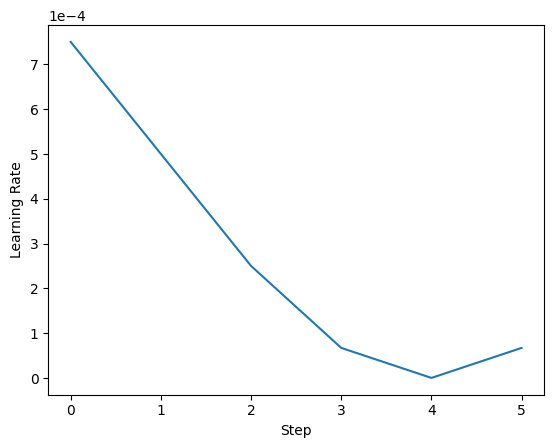

In [64]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = config.EPOCHS
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
model = CustomModel(num_classes=9)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=config.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.0,
    anneal_strategy="cos",
    final_div_factor=100,
)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

In [65]:
import pandas as pd
from sklearn.metrics import f1_score


class ParticipantVisibleError(Exception):
    """Errors raised here will be shown directly to the competitor."""
    pass


class CompetitionMetric:
    """Hierarchical macro F1 for the CMI 2025 challenge."""
    def __init__(self):
        self.target_gestures = [
            'Above ear - pull hair',
            'Cheek - pinch skin',
            'Eyebrow - pull hair',
            'Eyelash - pull hair',
            'Forehead - pull hairline',
            'Forehead - scratch',
            'Neck - pinch skin',
            'Neck - scratch',
        ]
        self.non_target_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]
        self.all_classes = self.target_gestures + self.non_target_gestures

    def calculate_hierarchical_f1(
        self,
        sol: pd.DataFrame,
        sub: pd.DataFrame
    ) -> float:

        # Validate gestures
        invalid_types = {i for i in sub['gesture'].unique() if i not in self.all_classes}
        if invalid_types:
            raise ParticipantVisibleError(
                f"Invalid gesture values in submission: {invalid_types}"
            )

        # Compute binary F1 (Target vs Non-Target)
        y_true_bin = sol['gesture'].isin(self.target_gestures).values
        y_pred_bin = sub['gesture'].isin(self.target_gestures).values
        f1_binary = f1_score(
            y_true_bin,
            y_pred_bin,
            pos_label=True,
            zero_division=0,
            average='binary'
        )

        # Build multi-class labels for gestures
        y_true_mc = sol['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')
        y_pred_mc = sub['gesture'].apply(lambda x: x if x in self.target_gestures else 'non_target')

        # Compute macro F1 over all gesture classes
        f1_macro = f1_score(
            y_true_mc,
            y_pred_mc,
            average='macro',
            zero_division=0
        )
        f1_mean = 0.5 * f1_binary + 0.5 * f1_macro
        return f1_mean, f1_binary, f1_macro


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str
) -> float:
    """
    Compute hierarchical macro F1 for the CMI 2025 challenge.

    Expected input:
      - solution and submission as pandas.DataFrame
      - Column 'sequence_id': unique identifier for each sequence
      - 'gesture': one of the eight target gestures or "Non-Target"

    This metric averages:
    1. Binary F1 on SequenceType (Target vs Non-Target)
    2. Macro F1 on gesture (mapping non-targets to "Non-Target")

    Raises ParticipantVisibleError for invalid submissions,
    including invalid SequenceType or gesture values.


    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> solution = pd.DataFrame({'id': range(4), 'gesture': ['Eyebrow - pull hair']*4})
    >>> submission = pd.DataFrame({'id': range(4), 'gesture': ['Forehead - pull hairline']*4})
    >>> score(solution, submission, row_id_column_name=row_id_column_name)
    0.5
    >>> submission = pd.DataFrame({'id': range(4), 'gesture': ['Text on phone']*4})
    >>> score(solution, submission, row_id_column_name=row_id_column_name)
    0.0
    >>> score(solution, solution, row_id_column_name=row_id_column_name)
    1.0
    """
    # Validate required columns
    for col in (row_id_column_name, 'gesture'):
        if col not in solution.columns:
            raise ParticipantVisibleError(f"Solution file missing required column: '{col}'")
        if col not in submission.columns:
            raise ParticipantVisibleError(f"Submission file missing required column: '{col}'")

    metric = CompetitionMetric()
    return metric.calculate_hierarchical_f1(solution, submission)

In [66]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train()
    criterion1 = nn.CrossEntropyLoss(reduction="mean")
    criterion2 = nn.BCEWithLogitsLoss()
    scaler = torch.amp.GradScaler(enabled=config.AMP)
    losses, losses1, losses2 = AverageMeter(), AverageMeter(), AverageMeter()
    start = end = time.time()
    global_step = 0
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            X = batch.pop("X").to(device) # send inputs to `device`
            y = batch.pop("y").to(device) # send labels to `device`
            y_hard = batch.pop("y_hard").to(device)
            batch_size = y.size(0)
            with torch.amp.autocast(device.type, enabled=config.AMP):
                y_preds, y_preds_hard = model(X)
                loss1 = criterion1(y_preds, y)
                loss2 = criterion2(y_preds_hard, y_hard.unsqueeze(1))
                loss = loss1 + loss2 
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            losses1.update(loss1.item(), batch_size)
            losses2.update(loss2.item(), batch_size)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
            
            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step()
            end = time.time()

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print(
                    'Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.avg:.4f} '
                    'Loss CE: {loss1.avg:.4f} '
                    'Loss BCE: {loss2.avg:.4f} '
                    'Grad: {grad_norm:.4f}  '
                    'LR: {lr:.8f}  '
                    .format(
                        epoch+1, step, len(train_loader), 
                        remain=timeSince(start, float(step+1)/len(train_loader)),
                        loss=losses, loss1=losses1, loss2=losses2,
                        grad_norm=grad_norm,
                        lr=scheduler.get_last_lr()[0]
                    )
                )

    return losses.avg


def valid_epoch(valid_loader, model, device):
    model.eval() 
    criterion1 = nn.CrossEntropyLoss(reduction="mean")
    criterion2 = nn.BCEWithLogitsLoss()
    softmax = nn.Softmax(dim=1)
    losses, losses1, losses2 = AverageMeter(), AverageMeter(), AverageMeter()
    predictions = {}
    all_preds, all_trues, all_ids = [] , [],  []
    start = end = time.time()
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            X = batch.pop("X").to(device) 
            y = batch.pop("y").to(device)
            y_hard = batch.pop("y_hard").to(device)
            sequence_ids = batch.pop("sequence_id")
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds, y_preds_hard = model(X)
                loss1 = criterion1(y_preds, y)
                loss2 = criterion2(y_preds_hard, y_hard.unsqueeze(1))
                loss = loss1 + loss2
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size)
            losses1.update(loss1.item(), batch_size)
            losses2.update(loss2.item(), batch_size)
            y_preds = softmax(y_preds)
            all_preds.append(y_preds.to('cpu').numpy())
            all_trues.append(y.to('cpu').numpy())
            all_ids += sequence_ids
            end = time.time()
            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Loss CE: {loss1.avg:.4f} '
                      'Loss BCE: {loss2.avg:.4f} '
                      .format(
                          step, len(valid_loader),
                          remain=timeSince(start, float(step+1)/len(valid_loader)),
                          loss=losses, loss1=losses1, loss2=losses2
                        )
                     )

    y_pred_proba = np.concatenate(all_preds)
    predictions["sequence_id"] = all_ids
    predictions["y_pred"] = np.argmax(y_pred_proba, axis=1)
    predictions["y_true"] = np.concatenate(all_trues)
    df_preds = pd.DataFrame(predictions)
    return losses.avg, df_preds, y_pred_proba

In [67]:
def train_loop(df, fold):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = df_train[df_train['fold'] != fold].reset_index(drop=True)
    valid_folds = df_train[df_train['fold'] == fold].reset_index(drop=True)
    
    all_sequences = df_train.sequence_id.unique()
    train_sequences = train_folds.sequence_id.unique()
    valid_sequences = valid_folds.sequence_id.unique()
    train_index = [np.where(all_sequences == item)[0][0] for item in train_sequences]
    valid_index = [np.where(all_sequences == item)[0][0] for item in valid_sequences]
    
    X_train, X_valid = all_X[train_index], all_X[valid_index]
    y_train, y_valid = all_y[train_index], all_y[valid_index]
    y_hard_train, y_hard_valid = all_y_hard[train_index], all_y_hard[valid_index]
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, X_train, y_train, y_hard_train)
    valid_dataset = CustomDataset(config, valid_folds, X_valid, y_valid, y_hard_valid)
    
    if config.DEBUG:
        train_dataset = Subset(train_dataset, list(range(config.BATCH_SIZE_TRAIN * 2)))
        config.EPOCHS = 2
        
    # ======== DATALOADERS ==========
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE_TRAIN,
        shuffle=True,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.BATCH_SIZE_VALID,
        shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False
    )
    
    # ======== MODEL ==========
    model = CustomModel(num_classes=9)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=config.LEARNING_RATE,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.0,
        anneal_strategy="cos",
        final_div_factor=100,
    )
    
    best_score = 0
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, df_preds, y_pred_proba = valid_epoch(valid_loader, model, device)
        solution, submission = format_for_scoring(df_preds)
        avg_score, f1_binary, f1_macro = score(solution, submission, "id")
        # ======= SCORING ==========
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        
        if avg_score > best_score:
            best_score = avg_score
            LOGGER.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model | F1-binary: {f1_binary} | F1-macro: {f1_macro}'
            )
            # === Save ===
            torch.save(
                model.state_dict(),
                paths.OUTPUT_DIR + f"/wavenet_fold_{fold}_best.pth"
            )
            df_preds.to_csv(paths.OUTPUT_DIR + f"/valid_{fold}.csv", index=False)
            np.save(paths.OUTPUT_DIR + f"/y_pred_proba_{fold}.npy", y_pred_proba)
        else:
            print(f"Score: {avg_score} | F1-binary: {f1_binary} | F1-macro: {f1_macro}")

    torch.cuda.empty_cache()
    gc.collect()
    
    return df_preds

In [69]:
if not config.TRAIN_FULL_DATA:
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0, 1, 2, 3, 4]:
            _oof_df = train_loop(df_train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== Fold {fold} finished ==========")
    oof_df = oof_df.reset_index(drop=True)
    oof_df.to_csv(paths.OUTPUT_DIR + f"/oof_df.csv", index=False)
else:
    train_loop_full_data(train_df)

========== Fold: 0 training ==========
========== Fold: 0 training ==========
========== Fold: 0 training ==========
Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  2.34train_batch/s]

Epoch: [1][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6551 Loss CE: 1.9575 Loss BCE: 0.6976 Grad: 27.5829  LR: 0.00075010  


Train: 100%|██████████| 2/2 [00:00<00:00,  2.32train_batch/s]


Epoch: [1][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6666 Loss CE: 2.0281 Loss BCE: 0.6385 Grad: 35.9487  LR: 0.00050020  


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.90valid_batch/s]
Epoch 1 - avg_train_loss: 2.6666  avg_val_loss: 2.6065  time: 1s
Epoch 1 - avg_train_loss: 2.6666  avg_val_loss: 2.6065  time: 1s
Epoch 1 - avg_train_loss: 2.6666  avg_val_loss: 2.6065  time: 1s
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 0.0 | F1-macro: 1.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 0.0 | F1-macro: 1.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 0.0 | F1-macro: 1.0


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6065 Loss CE: 1.4910 Loss BCE: 1.1155 


Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  2.15train_batch/s]

Epoch: [2][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.1664 Loss CE: 1.8160 Loss BCE: 0.3504 Grad: 28.1357  LR: 0.00025030  


Train: 100%|██████████| 2/2 [00:00<00:00,  2.33train_batch/s]


Epoch: [2][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.0326 Loss CE: 1.5085 Loss BCE: 0.5242 Grad: 22.2956  LR: 0.00006736  


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.99valid_batch/s]
Epoch 2 - avg_train_loss: 2.0326  avg_val_loss: 2.6610  time: 1s
Epoch 2 - avg_train_loss: 2.0326  avg_val_loss: 2.6610  time: 1s
Epoch 2 - avg_train_loss: 2.0326  avg_val_loss: 2.6610  time: 1s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6610 Loss CE: 1.4823 Loss BCE: 1.1787 
Score: 0.5 | F1-binary: 0.0 | F1-macro: 1.0


Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  2.57train_batch/s]

Epoch: [3][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.5491 Loss CE: 1.8720 Loss BCE: 0.6771 Grad: 28.1377  LR: 0.00000040  


Train: 100%|██████████| 2/2 [00:00<00:00,  2.43train_batch/s]


Epoch: [3][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.2893 Loss CE: 1.6661 Loss BCE: 0.6232 Grad: 30.1077  LR: 0.00006736  


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.32valid_batch/s]
Epoch 3 - avg_train_loss: 2.2893  avg_val_loss: 2.6677  time: 1s
Epoch 3 - avg_train_loss: 2.2893  avg_val_loss: 2.6677  time: 1s
Epoch 3 - avg_train_loss: 2.2893  avg_val_loss: 2.6677  time: 1s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6677 Loss CE: 1.4965 Loss BCE: 1.1712 
Score: 0.0 | F1-binary: 0.0 | F1-macro: 0.0


========== Fold 0 finished ==========
========== Fold 0 finished ==========
========== Fold 0 finished ==========
========== Fold: 1 training ==========
========== Fold: 1 training ==========
========== Fold: 1 training ==========
Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  2.28train_batch/s]

Epoch: [1][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6134 Loss CE: 1.9875 Loss BCE: 0.6259 Grad: 46.4967  LR: 0.00075010  


Train: 100%|██████████| 2/2 [00:00<00:00,  2.34train_batch/s]


Epoch: [1][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6628 Loss CE: 2.0921 Loss BCE: 0.5707 Grad: 21.0566  LR: 0.00050020  


Validation: 100%|██████████| 1/1 [00:00<00:00, 12.27valid_batch/s]
Epoch 1 - avg_train_loss: 2.6628  avg_val_loss: 2.4112  time: 1s
Epoch 1 - avg_train_loss: 2.6628  avg_val_loss: 2.4112  time: 1s
Epoch 1 - avg_train_loss: 2.6628  avg_val_loss: 2.4112  time: 1s
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 0.0 | F1-macro: 1.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 0.0 | F1-macro: 1.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 0.0 | F1-macro: 1.0


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.4112 Loss CE: 1.8786 Loss BCE: 0.5326 


Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  2.56train_batch/s]

Epoch: [2][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.0288 Loss CE: 1.5853 Loss BCE: 0.4435 Grad: 16.3504  LR: 0.00025030  


Train: 100%|██████████| 2/2 [00:00<00:00,  2.54train_batch/s]


Epoch: [2][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.2769 Loss CE: 1.7686 Loss BCE: 0.5083 Grad: 34.5438  LR: 0.00006736  


Validation: 100%|██████████| 1/1 [00:00<00:00, 18.89valid_batch/s]
Epoch 2 - avg_train_loss: 2.2769  avg_val_loss: 2.2380  time: 1s
Epoch 2 - avg_train_loss: 2.2769  avg_val_loss: 2.2380  time: 1s
Epoch 2 - avg_train_loss: 2.2769  avg_val_loss: 2.2380  time: 1s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.2380 Loss CE: 1.7377 Loss BCE: 0.5003 
Score: 0.5 | F1-binary: 0.0 | F1-macro: 1.0


Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  3.15train_batch/s]

Epoch: [3][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 1.6367 Loss CE: 1.2214 Loss BCE: 0.4153 Grad: 13.3860  LR: 0.00000040  


Train: 100%|██████████| 2/2 [00:00<00:00,  3.27train_batch/s]


Epoch: [3][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 1.9310 Loss CE: 1.3800 Loss BCE: 0.5510 Grad: 20.5141  LR: 0.00006736  


Validation: 100%|██████████| 1/1 [00:00<00:00, 17.92valid_batch/s]
Epoch 3 - avg_train_loss: 1.9310  avg_val_loss: 2.1969  time: 1s
Epoch 3 - avg_train_loss: 1.9310  avg_val_loss: 2.1969  time: 1s
Epoch 3 - avg_train_loss: 1.9310  avg_val_loss: 2.1969  time: 1s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.1969 Loss CE: 1.7092 Loss BCE: 0.4876 
Score: 0.5 | F1-binary: 0.0 | F1-macro: 1.0


========== Fold 1 finished ==========
========== Fold 1 finished ==========
========== Fold 1 finished ==========
========== Fold: 2 training ==========
========== Fold: 2 training ==========
========== Fold: 2 training ==========
Train:   0%|          | 0/1 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train: 100%|██████████| 1/1 [00:00<00:00,  3.25train_batch/s]


Epoch: [1][0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 3.2762 Loss CE: 2.3760 Loss BCE: 0.9002 Grad: 27.8704  LR: 0.00025030  


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.74valid_batch/s]
Epoch 1 - avg_train_loss: 3.2762  avg_val_loss: 2.8288  time: 0s
Epoch 1 - avg_train_loss: 3.2762  avg_val_loss: 2.8288  time: 0s
Epoch 1 - avg_train_loss: 3.2762  avg_val_loss: 2.8288  time: 0s
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 1.0 | F1-macro: 0.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 1.0 | F1-macro: 0.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 1.0 | F1-macro: 0.0


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.8288 Loss CE: 2.2636 Loss BCE: 0.5651 


Train:   0%|          | 0/1 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train: 100%|██████████| 1/1 [00:00<00:00,  3.12train_batch/s]


Epoch: [2][0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.6514 Loss CE: 1.9743 Loss BCE: 0.6771 Grad: 24.1159  LR: 0.00000040  


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.96valid_batch/s]
Epoch 2 - avg_train_loss: 2.6514  avg_val_loss: 2.8144  time: 0s
Epoch 2 - avg_train_loss: 2.6514  avg_val_loss: 2.8144  time: 0s
Epoch 2 - avg_train_loss: 2.6514  avg_val_loss: 2.8144  time: 0s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.8144 Loss CE: 2.2932 Loss BCE: 0.5213 
Score: 0.5 | F1-binary: 1.0 | F1-macro: 0.0


Train:   0%|          | 0/1 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train: 100%|██████████| 1/1 [00:00<00:00,  3.43train_batch/s]


Epoch: [3][0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.0761 Loss CE: 1.6924 Loss BCE: 0.3837 Grad: 22.3819  LR: 0.00025030  


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.32valid_batch/s]
Epoch 3 - avg_train_loss: 2.0761  avg_val_loss: 2.7823  time: 0s
Epoch 3 - avg_train_loss: 2.0761  avg_val_loss: 2.7823  time: 0s
Epoch 3 - avg_train_loss: 2.0761  avg_val_loss: 2.7823  time: 0s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.7823 Loss CE: 2.2724 Loss BCE: 0.5099 
Score: 0.5 | F1-binary: 1.0 | F1-macro: 0.0


========== Fold 2 finished ==========
========== Fold 2 finished ==========
========== Fold 2 finished ==========
========== Fold: 3 training ==========
========== Fold: 3 training ==========
========== Fold: 3 training ==========
Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  3.14train_batch/s]

Epoch: [1][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 3.0734 Loss CE: 2.4062 Loss BCE: 0.6671 Grad: 27.7768  LR: 0.00075010  


Train: 100%|██████████| 2/2 [00:00<00:00,  3.10train_batch/s]


Epoch: [1][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 2.8283 Loss CE: 2.2183 Loss BCE: 0.6100 Grad: 17.4770  LR: 0.00050020  


Validation: 100%|██████████| 1/1 [00:00<00:00, 17.58valid_batch/s]
Epoch 1 - avg_train_loss: 2.8283  avg_val_loss: 1.4591  time: 1s
Epoch 1 - avg_train_loss: 2.8283  avg_val_loss: 1.4591  time: 1s
Epoch 1 - avg_train_loss: 2.8283  avg_val_loss: 1.4591  time: 1s
Epoch 1 - Save Best Score: 1.0000 Model | F1-binary: 1.0 | F1-macro: 1.0
Epoch 1 - Save Best Score: 1.0000 Model | F1-binary: 1.0 | F1-macro: 1.0
Epoch 1 - Save Best Score: 1.0000 Model | F1-binary: 1.0 | F1-macro: 1.0


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 1.4591 Loss CE: 1.0512 Loss BCE: 0.4079 


Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  3.33train_batch/s]

Epoch: [2][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 1.5303 Loss CE: 1.2045 Loss BCE: 0.3258 Grad: 15.0700  LR: 0.00025030  


Train: 100%|██████████| 2/2 [00:00<00:00,  2.98train_batch/s]


Epoch: [2][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 1.7998 Loss CE: 1.4594 Loss BCE: 0.3404 Grad: 18.9419  LR: 0.00006736  


Validation: 100%|██████████| 1/1 [00:00<00:00, 18.07valid_batch/s]
Epoch 2 - avg_train_loss: 1.7998  avg_val_loss: 1.0414  time: 1s
Epoch 2 - avg_train_loss: 1.7998  avg_val_loss: 1.0414  time: 1s
Epoch 2 - avg_train_loss: 1.7998  avg_val_loss: 1.0414  time: 1s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 1.0414 Loss CE: 0.8260 Loss BCE: 0.2154 
Score: 1.0 | F1-binary: 1.0 | F1-macro: 1.0


Train:   0%|          | 0/2 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train:  50%|█████     | 1/2 [00:00<00:00,  3.24train_batch/s]

Epoch: [3][0/2] Elapsed 0m 0s (remain 0m 0s) Loss: 1.5091 Loss CE: 1.3235 Loss BCE: 0.1856 Grad: 14.6422  LR: 0.00000040  


Train: 100%|██████████| 2/2 [00:00<00:00,  3.20train_batch/s]


Epoch: [3][1/2] Elapsed 0m 0s (remain 0m 0s) Loss: 1.4602 Loss CE: 1.2637 Loss BCE: 0.1966 Grad: 11.0100  LR: 0.00006736  


Validation: 100%|██████████| 1/1 [00:00<00:00, 16.18valid_batch/s]
Epoch 3 - avg_train_loss: 1.4602  avg_val_loss: 1.1567  time: 1s
Epoch 3 - avg_train_loss: 1.4602  avg_val_loss: 1.1567  time: 1s
Epoch 3 - avg_train_loss: 1.4602  avg_val_loss: 1.1567  time: 1s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 1.1567 Loss CE: 0.9372 Loss BCE: 0.2195 
Score: 1.0 | F1-binary: 1.0 | F1-macro: 1.0


========== Fold 3 finished ==========
========== Fold 3 finished ==========
========== Fold 3 finished ==========
========== Fold: 4 training ==========
========== Fold: 4 training ==========
========== Fold: 4 training ==========
Train:   0%|          | 0/1 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train: 100%|██████████| 1/1 [00:00<00:00,  2.92train_batch/s]


Epoch: [1][0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 3.1989 Loss CE: 2.3917 Loss BCE: 0.8072 Grad: 22.4058  LR: 0.00025030  


Validation: 100%|██████████| 1/1 [00:00<00:00, 13.00valid_batch/s]
Epoch 1 - avg_train_loss: 3.1989  avg_val_loss: 2.9687  time: 0s
Epoch 1 - avg_train_loss: 3.1989  avg_val_loss: 2.9687  time: 0s
Epoch 1 - avg_train_loss: 3.1989  avg_val_loss: 2.9687  time: 0s
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 1.0 | F1-macro: 0.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 1.0 | F1-macro: 0.0
Epoch 1 - Save Best Score: 0.5000 Model | F1-binary: 1.0 | F1-macro: 0.0


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.9687 Loss CE: 2.2585 Loss BCE: 0.7102 


Train:   0%|          | 0/1 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train: 100%|██████████| 1/1 [00:00<00:00,  3.19train_batch/s]


Epoch: [2][0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.4262 Loss CE: 1.9115 Loss BCE: 0.5147 Grad: 96.3130  LR: 0.00000040  


Validation: 100%|██████████| 1/1 [00:00<00:00,  9.87valid_batch/s]
Epoch 2 - avg_train_loss: 2.4262  avg_val_loss: 2.9768  time: 0s
Epoch 2 - avg_train_loss: 2.4262  avg_val_loss: 2.9768  time: 0s
Epoch 2 - avg_train_loss: 2.4262  avg_val_loss: 2.9768  time: 0s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.9768 Loss CE: 2.2980 Loss BCE: 0.6789 
Score: 0.5 | F1-binary: 1.0 | F1-macro: 0.0


Train:   0%|          | 0/1 [00:00<?, ?train_batch/s]d:\dev\kaggle1\env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

Train: 100%|██████████| 1/1 [00:00<00:00,  3.17train_batch/s]


Epoch: [3][0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.4870 Loss CE: 2.1051 Loss BCE: 0.3819 Grad: 52.6055  LR: 0.00025030  


Validation: 100%|██████████| 1/1 [00:00<00:00,  8.18valid_batch/s]
Epoch 3 - avg_train_loss: 2.4870  avg_val_loss: 2.9982  time: 0s
Epoch 3 - avg_train_loss: 2.4870  avg_val_loss: 2.9982  time: 0s
Epoch 3 - avg_train_loss: 2.4870  avg_val_loss: 2.9982  time: 0s


EVAL: [0/1] Elapsed 0m 0s (remain 0m 0s) Loss: 2.9982 Loss CE: 2.3162 Loss BCE: 0.6820 
Score: 0.5 | F1-binary: 1.0 | F1-macro: 0.0


========== Fold 4 finished ==========
========== Fold 4 finished ==========
========== Fold 4 finished ==========
